In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import dotenv
from pathlib import Path

env_file = "../.env"

if os.path.exists(env_file):
    dotenv.load_dotenv(env_file, verbose=True)
    print("Loaded environment variables from .env file.")

cwd = os.getcwd()
# for some reason appending to PATH you need it to be string
sys.path.append(str(Path(cwd).parent / "src"))
hf_access_token = os.getenv("HUGGINGFACE_API_KEY")

# from research_tools.gpu import get_gpus_available
# os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in get_gpus_available()])

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Loaded environment variables from .env file.


In [2]:
from torchvision import datasets, transforms
import torch


tensor_transform = transforms.Compose([transforms.ToTensor()])

batch_size = 256
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=tensor_transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=tensor_transform
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

In [3]:
import torch
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device == torch.device("cuda")


class EDMVel(torch.nn.Module):
    def __init__(self, model=None):
        super().__init__()
        self.device = device
        self.model = model.to(self.device)
        self.ema = copy.deepcopy(self.model).eval().requires_grad_(False)
        ## parameters
        self.sigma_min = 0.002
        self.sigma_max = 80.0
        self.rho = 7.0
        self.sigma_data = 0.5
        self.P_mean = -1.2
        self.P_std = 1.2
        self.sigma_data = 0.5
        self.ema_rampup_ratio = 0.05
        self.ema_halflife_kimg = 500
        self.drop_prob = 0.1

    def forward(
        self,
        x_,
        sigma_,
        class_labels=None,
        augment_labels=None,
        force_fp32=False,
        use_ema=False,
        **model_kwargs
    ):
        # sigma_[sigma_>0.988] = 0.988
        # Assume sigma_ is in [0.001, 80/81].
        # assert (sigma_ >= 0.001).all() and (sigma_ <= 80/81).all()
        # Rescale x and sigma.
        x = x_ / (1 - sigma_).view(-1, 1, 1, 1)
        sigma = sigma_ / (1 - sigma_)

        # Compute posterior mean D_x
        x = x.to(torch.float32)
        # augment_labels = torch.zeros([x.shape[0], self.augment_dim], device = x.device)
        sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)
        # class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim], device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float32

        c_skip = self.sigma_data**2 / (sigma**2 + self.sigma_data**2)
        c_out = sigma * self.sigma_data / (sigma**2 + self.sigma_data**2).sqrt()
        c_in = 1 / (self.sigma_data**2 + sigma**2).sqrt()
        c_noise = sigma.log() / 4

        if use_ema:
            F_x = self.ema(
                (c_in * x).to(dtype),
                c_noise.flatten(),
                class_labels=class_labels,
                **model_kwargs
            )
        else:
            F_x = self.model(
                (c_in * x).to(dtype),
                c_noise.flatten(),
                class_labels=class_labels,
                **model_kwargs
            )
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)

        # Compute v_t
        v_t = (x_ - D_x) / sigma_.view(-1, 1, 1, 1)
        return v_t

    def update_ema(self, step):
        ema_halflife_nimg = self.ema_halflife_kimg * 1000
        if self.ema_rampup_ratio is not None:
            ema_halflife_nimg = min(
                ema_halflife_nimg, step * batch_size * self.ema_rampup_ratio
            )
        ema_beta = 0.5 ** (batch_size / max(ema_halflife_nimg, 1e-8))
        for p_ema, p_net in zip(self.ema.parameters(), self.model.parameters()):
            p_ema.copy_(p_net.detach().lerp(p_ema, ema_beta))

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

In [4]:
from networks_edm import SongUNet


def create_model():
    unet = SongUNet(
        in_channels=1,
        out_channels=1,
        num_blocks=2,
        attn_resolutions=[0],
        model_channels=32,
        channel_mult=[1, 2, 2],
        dropout=0.13,
        img_resolution=28,
        label_dim=10,
        label_dropout=0.1,
        embedding_type="positional",
        encoder_type="standard",
        decoder_type="standard",
        augment_dim=0,
        channel_mult_noise=1,
        resample_filter=[1, 1],
    )
    pytorch_total_grad_params = sum(
        p.numel() for p in unet.parameters() if p.requires_grad
    )
    print(
        f"total number of trainable parameters in the Score Model: {pytorch_total_grad_params}"
    )
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f"total number of parameters in the Score Model: {pytorch_total_params}")
    return unet

In [49]:
import torch
from pathlib import Path


model_path = Path("edm_model_checkpoint.pth")

unet = create_model().to(device)
unet.load_state_dict(torch.load(model_path))

total number of trainable parameters in the Score Model: 1703041
total number of parameters in the Score Model: 1703041


/tmp/ipykernel_2875864/709536505.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [50]:
v_edm = EDMVel(model=unet)

In [7]:
def get_split_time_schedule(n_steps_1, n_steps_2, split=0.5):
    time_schedule = []
    split = 1 - split
    for i in range(n_steps_2):
        time_schedule += [split * (i / n_steps_2)]

    for i in range(n_steps_1 + 1):
        time_schedule += [split + (1 - split) * (i / n_steps_1)]

    time_schedule = list(reversed(time_schedule))
    time_schedule[0] = 1 - 1e-5
    return time_schedule

In [41]:
import random
from tqdm import tqdm
from torch import nn


@torch.no_grad()
def v_edm_sampler(
    v_edm,
    latents,
    class_labels=None,
    num_steps=18,
    guide_w=0.0,
    use_ema=True,
    cfg=True,
    drop_prob=0.0,
    suppress_print=False,
):
    time_schedule = [(i / num_steps) for i in reversed(range(1, num_steps + 1))] + [0]
    time_schedule[0] = 1 - 1e-5
    # time_schedule = get_split_time_schedule(6, 12)
    cnt = 0
    if not suppress_print:
        print(f"Time schedule: {time_schedule}")

    if class_labels is not None:
        class_labels = (
            nn.functional.one_hot(class_labels, num_classes=10)
            .type(torch.float32)
            .to(latents.device)
        )
        mask = torch.bernoulli(torch.ones_like(class_labels) * (1 - drop_prob))
        class_labels = class_labels * mask
        if cfg:
            class_labels = torch.cat([class_labels, torch.zeros_like(class_labels)])
    # Main sampling loop.
    x_next = latents.to(torch.float64).to(device) * time_schedule[0]

    rand_x = random.choice([10 + i for i in range(8)])
    rand_y = random.choice([10 + i for i in range(8)])

    random_trajs = [
        [x_next[i, 0, rand_x, rand_y].detach().cpu().item()]
        for i in range(latents.shape[0])
    ]
    middle = None
    for i in tqdm(range(len(time_schedule[:-1]))):
        t = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=device)
            * time_schedule[i]
        )
        t_next = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=x_next.device)
            * time_schedule[i + 1]
        )
        dt = t_next[0] - t[0]
        if cfg:
            x_hat = x_next.repeat(2, 1, 1, 1)
        else:
            x_hat = x_next

        vt = v_edm(x_hat, t, class_labels, use_ema=use_ema).to(torch.float64)
        x_next = x_hat + vt * dt

        # cfg guide
        if cfg:
            x_next_cond, x_next_uncond = x_next.chunk(2)
            x_next = (1 + guide_w) * x_next_cond - guide_w * x_next_uncond
        if i == (num_steps // 2):
            middle = x_next.clone().detach()

    return x_next, middle, class_labels

In [53]:
def generate_batch(batch_size: int):

    x_T = torch.randn([batch_size, 1, 28, 28], device=device)
    # random from 0 to 9 inclusive
    c = torch.randint(0, 10, (batch_size,), device=device)
    x_gen, _, c = v_edm_sampler(
        v_edm, x_T, class_labels=c, num_steps=18, guide_w=4.5, suppress_print=True
    )
    # x_gen = (x_gen / 2 + 0.5).clamp(0, 1)
    return x_gen

In [10]:
import numpy as np
import torch
from torchvision.transforms import functional as TF
from torchvision.models import inception_v3
from scipy.stats import entropy
from torchvision.utils import make_grid


# Function to preprocess MNIST images for Inception-v3
def preprocess_for_inception(images):
    # Rescale images to 299x299 and convert to RGB
    images = torch.stack([TF.resize(img, (299, 299)) for img in images])
    images = images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB
    return images


# Function to compute Inception Score
def compute_inception_score(num_samples=5000, batch_size=32, splits=10, device="cuda"):
    """
    Computes the Inception Score for a generative model.
    - generator: the generative model that generates MNIST images
    - num_samples: number of samples to generate for evaluation
    - batch_size: number of images per batch
    - splits: number of splits for the score calculation
    - device: 'cuda' or 'cpu'
    """
    # Load the Inception-v3 model
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.double()
    inception.eval()

    # Generate samples
    all_preds = []
    with torch.no_grad():
        for _ in range(num_samples // batch_size):
            # Generate images

            fake_images = generate_batch(batch_size)
            fake_images = preprocess_for_inception(fake_images)
            # should be double
            fake_images = fake_images.to(torch.float64)

            # Compute predictions
            preds = torch.softmax(inception(fake_images), dim=1)
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)

    # Compute Inception Score
    split_scores = []
    for k in range(splits):
        part = all_preds[
            k * (num_samples // splits) : (k + 1) * (num_samples // splits)
        ]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


v_edm.eval()

is_mean, is_std = compute_inception_score(
    num_samples=1000, batch_size=1000, splits=5, device="cuda"
)
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")

/mnt/align1_drive/tcqian/unlearning_order/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/align1_drive/tcqian/unlearning_order/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 18/18 [00:01<00:00, 11.88it/s]


Inception Score: 1.95 ± 0.04


In [11]:
num_steps = 10
time_schedule = [(i / num_steps) for i in reversed(range(1, num_steps + 1))] + [0]
time_schedule[0] = 1 - 1e-5
print(time_schedule, len(time_schedule))

[0.99999, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0] 11


In [12]:
n_steps_1 = 6
n_steps_2 = 3

# split 0.5
time_schedule = []
for i in range(n_steps_2):
    time_schedule += [0.5 * (i / n_steps_2)]

for i in range(n_steps_1 + 1):
    time_schedule += [0.5 + 0.5 * (i / n_steps_1)]

time_schedule = list(reversed(time_schedule))
time_schedule[0] = 1 - 1e-5
print(time_schedule, len(time_schedule))

[0.99999, 0.9166666666666667, 0.8333333333333333, 0.75, 0.6666666666666666, 0.5833333333333334, 0.5, 0.3333333333333333, 0.16666666666666666, 0.0] 10


In [30]:
import numpy as np
import torch
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F


# Preprocessing for MNIST to fit Inception-v3 input
def preprocess_mnist(images):
    """
    Resize MNIST images to 299x299 and convert grayscale to RGB.
    Args:
        images (torch.Tensor): MNIST images (B, 1, 28, 28)
    Returns:
        torch.Tensor: Preprocessed images (B, 3, 299, 299)
    """
    transform = Compose(
        [
            Resize((299, 299)),
            Normalize(mean=[0.5], std=[0.5]),  # Normalize grayscale images
        ]
    )
    images = images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB
    images = torch.stack([transform(img) for img in images])  # Apply transformations
    return images


# Compute the FID score
def compute_fid(real_loader, fake_loader, device="cuda"):
    """
    Compute FID score between real and generated images.
    Args:
        real_loader (DataLoader): DataLoader for real images.
        fake_loader (DataLoader): DataLoader for generated images.
        device (str): Device to run the computations ('cuda' or 'cpu').
    Returns:
        float: FID score.
    """
    # Load Inception-v3 model
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()
    inception.double()

    def get_activations(data_loader):
        activations = []
        with torch.no_grad():
            for batch in data_loader:
                images, _ = batch  # Labels are not needed
                images = preprocess_mnist(images).to(device)  # Apply preprocessing here
                images = images.to(torch.double)
                preds = inception(images)
                activations.append(preds.cpu().numpy())
        return np.concatenate(activations, axis=0)

    # Compute activations for real and fake images
    real_activations = get_activations(real_loader)
    fake_activations = get_activations(fake_loader)

    # Calculate mean and covariance of activations
    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(
        real_activations, rowvar=False
    )
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(
        fake_activations, rowvar=False
    )

    # Compute FID score using the formula
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real @ sigma_fake)
    # Handle numerical issues
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

In [66]:
# Load MNIST dataset for real images
real_dataset = MNIST(root="./data", train=False, transform=ToTensor(), download=True)
use_len = 1000

real_dataset = torch.utils.data.Subset(real_dataset, list(range(use_len)))

real_loader = DataLoader(real_dataset, batch_size=32, shuffle=False)

v_edm.eval()
# Generate a dataset of fake images
fake_images = []

fake_images = generate_batch(len(real_dataset))
fake_images = fake_images.to(torch.float64)
# list
fake_images_list = []
for i in range(len(fake_images)):
    fake_images_list.append((fake_images[i].detach().cpu(), 0))

fake_images = fake_images_list


fake_loader = DataLoader(fake_images, batch_size=32, shuffle=False)

100%|██████████| 18/18 [00:01<00:00, 14.66it/s]


In [67]:
# Compute FID score
fid_score = compute_fid(real_loader, fake_loader, device="cuda")
print(f"FID Score: {fid_score:.2f}")

/mnt/align1_drive/tcqian/unlearning_order/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/align1_drive/tcqian/unlearning_order/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 305.43


In [78]:
d = None
for x in real_loader:
    d = x[0][2]
    break

100%|██████████| 18/18 [00:00<00:00, 76.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0608598068356514..1.0691249370574951].


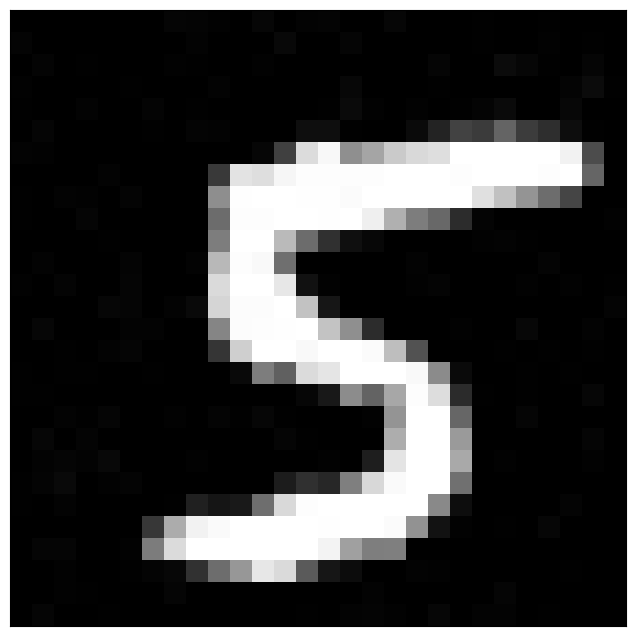

: 

In [ ]:
# plot fake_images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))


fake = generate_batch(1).detach().cpu()
show_images(fake[0], nmax=32)
# show_images(d, nmax=32)

In [57]:
fake.min()

tensor(-0.0258, dtype=torch.float64)

In [58]:
fake.max()

tensor(1.0173, dtype=torch.float64)